<a href="https://colab.research.google.com/github/Mbigdeli2003/Reinforcement-Learning/blob/main/Sutton_4_7_Nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sutton 4.7.Exercise

### Importing Libraries

In [ ]:
#IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
import sys

###Defining Problem Parameters



In [ ]:
#Problem Parameters
class jcp:
    @staticmethod
    def max_cars():
        return 20

    @staticmethod
    def γ():
        return 0.9

    @staticmethod
    def credit_reward():
        return 10

    @staticmethod
    def moving_reward():
        return -2

    @staticmethod
    def second_parking_lot_reward():
        return -4     # incrring 4$

Poisson Function

In [ ]:
class poisson_:

    def __init__(self, λ):
        self.λ = λ

        ε = 0.01


        # [α , β] is the range of n's for which the pmf value is above ε
        self.α = 0
        state = 1
        self.vals = {}
        summer = 0

        while(1):
            if state == 1:
                temp = poisson.pmf(self.α, self.λ)
                if(temp <= ε):
                    self.α+=1
                else:
                    self.vals[self.α] = temp
                    summer += temp
                    self.β = self.α+1
                    state = 2
            elif state == 2:
                temp = poisson.pmf(self.β, self.λ)
                if(temp > ε):
                    self.vals[self.β] = temp
                    summer += temp
                    self.β+=1
                else:
                    break

        # normalizing the pmf, values of n outside of [α, β] have pmf = 0

        added_val = (1-summer)/(self.β-self.α)
        for key in self.vals:
            self.vals[key] += added_val


    def f(self, n):
        try:
            Ret_value = self.vals[n]
        except(KeyError):
            Ret_value = 0
        finally:
            return Ret_value

### initial location

In [ ]:
class location:

    def __init__(self, req, ret):
        self.α = req                             #value of lambda for requests
        self.β = ret                             #value of lambda for returns
        self.poissonα = poisson_(self.α)
        self.poissonβ = poisson_(self.β)

In [ ]:
# First Location
A = location(3,3)
B = location(4,2)
A
B

### Policy Matrice initilize

In [ ]:
value = np.zeros((jcp.max_cars()+1, jcp.max_cars()+1))
policy = value.copy().astype(int)

In [ ]:
#Applying Action def init
def apply_action(state, action):
    return [max(min(state[0] - action, jcp.max_cars()),0) , max(min(state[1] + action, jcp.max_cars()),0)]

###Def for Expected reward

In [ ]:

def expected_reward(state, action):
    global value
    """
    state  : It's a pair of integers, # of cars at A and at B
    action : # of cars transferred from A to B,  -5 <= action <= 5
    """


    ψ = 0 #reward
    new_state = apply_action(state, action)

    # adding reward for moving cars from one location to another (which is negative)

    if action <= 0:
        ψ = ψ + jcp.moving_reward() * abs(action)
    else:
        ψ = ψ + jcp.moving_reward() * (action - 1)    #one car is moved by one of Jack's employees for free

    # adding reward for second parking lot (which is also negative)

    if new_state[0] > 10:
        ψ = ψ + jcp.second_parking_lot_reward()

    if new_state[1] > 10:
        ψ = ψ + jcp.second_parking_lot_reward()

    # there are four discrete random variables which determine the probability distribution of the reward and next state

    for Aα in range(A.poissonα.α, A.poissonα.β):
        for Bα in range(B.poissonα.α, B.poissonα.β):
            for Aβ in range(A.poissonβ.α, A.poissonβ.β):
                for Bβ in range(B.poissonβ.α, B.poissonβ.β):
                    """
                    Aα : sample of cars requested at location A
                    Aβ : sample of cars returned at location A
                    Bα : sample of cars requested at location B
                    Bβ : sample of cars returned at location B
                    ζ  : probability of this event happening
                    """

                    # all four variables are independent of each other
                    ζ = A.poissonα.vals[Aα] * B.poissonα.vals[Bα] * A.poissonβ.vals[Aβ] * B.poissonβ.vals[Bβ]

                    valid_requests_A = min(new_state[0], Aα)
                    valid_requests_B = min(new_state[1], Bα)

                    rew = (valid_requests_A + valid_requests_B)*(jcp.credit_reward())

                    #calculating the new state based on the values of the four random variables
                    new_s = [0,0]
                    new_s[0] = max(min(new_state[0] - valid_requests_A + Aβ, jcp.max_cars()),0)
                    new_s[1] = max(min(new_state[1] - valid_requests_B + Bβ, jcp.max_cars()),0)

                    #Bellman's equation
                    ψ += ζ * (rew + jcp.γ() * value[new_s[0]][new_s[1]])

    return ψ

## Policy

In [ ]:
def policy_evaluation():

    global value

    # here policy_evaluation has a static variable ε whose values decreases over time
    ε = policy_evaluation.ε

    policy_evaluation.ε /= 10

    while(1):
        δ = 0

        for i in range(value.shape[0]):
            for j in range(value.shape[1]):
                # value[i][j] denotes the value of the state [i,j]

                old_val = value[i][j]
                value[i][j] = expected_reward([i,j], policy[i][j])

                δ = max(δ, abs(value[i][j] - old_val))
                print('.', end = '')
                sys.stdout.flush()
        print(δ)
        sys.stdout.flush()

        if δ < ε:
            break

### Policy Improvemnet

In [ ]:
#initial value of ε
policy_evaluation.ε = 50
def policy_improvement():

    global policy

    policy_stable = True
    for i in range(value.shape[0]):
        for j in range(value.shape[1]):
            old_action = policy[i][j]

            max_act_val = None
            max_act = None

            τ12 = min(i,5)       # if I have say 3 cars at the first location, then I can atmost move 3 from 1 to 2
            τ21 = -min(j,5)      # if I have say 2 cars at the second location, then I can atmost move 2 from 2 to 1

            for act in range(τ21,τ12+1):
                σ = expected_reward([i,j], act)
                if max_act_val == None:
                    max_act_val = σ
                    max_act = act
                elif max_act_val < σ:
                    max_act_val = σ
                    max_act = act

            policy[i][j] = max_act

            if old_action!= policy[i][j]:
                policy_stable = False

    return policy_stable

In [ ]:
def save_policy():
    save_policy.counter += 1
    ax = sns.heatmap(policy, linewidth=0.5)
    ax.invert_yaxis()
    plt.savefig('policy'+str(save_policy.counter)+'.svg')
    plt.title('Policy')
    plt.show()


In [ ]:
def save_value():
    save_value.counter += 1
    ax = sns.heatmap(value, linewidth=0.5)
    ax.invert_yaxis()
    plt.savefig('value'+ str(save_value.counter)+'.svg')
    plt.title('value')
    plt.show()


### Policy Evalution, Policy Improvement

.........................................................................................................................................................................................................................................................................................................................................................................................................................................................3.410605131648481e-12
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................2.9558577807620168e-12
.........................................................................

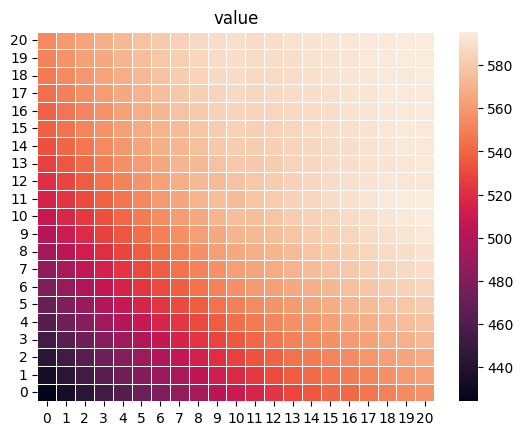

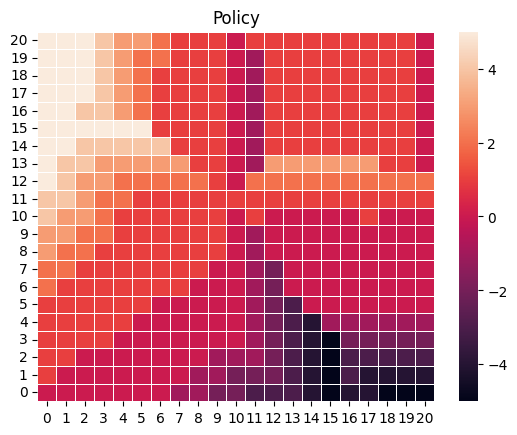

In [ ]:
#loop Continues (policy Improvemnet) until Policy get stable
save_policy.counter = 0
save_value.counter = 0
while(1):
    policy_evaluation()
    ρ = policy_improvement()
    save_value()
    save_policy()
    if ρ == True:
        break